# Let's explore how sensitivity looks in very simple networks

In [1]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from ei import topology_of, EI_of_layer, sensitivity_of_layer

In [2]:
# Pretty colormaps
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))
                    
def rainbowMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("rainbow")
    return colormap(1.0 * pos / size)

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(1.0 * pos / size)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


## EI: A -> B Sigmoid (blue)

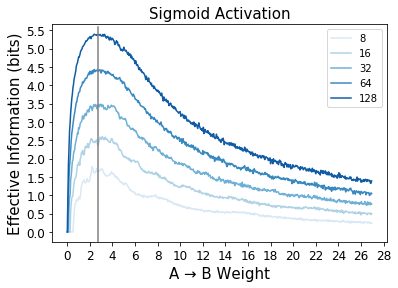

In [4]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(0, 1), out_range=(0, 1), activation=nn.Sigmoid(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("Sigmoid Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend()

# plt.savefig("figures/sigmoid-1d-blue", dpi=300)

## Sensitivity: A -> B Sigmoid (blue)

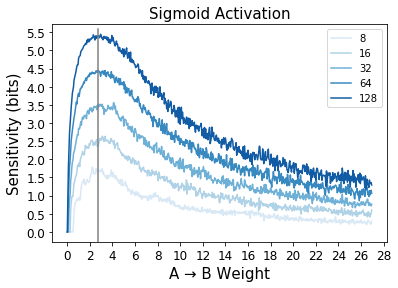

In [5]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    sens = []
    for w in ws:
        singleton.weight.data[0][0] = w
        sensitivity = sensitivity_of_layer(singleton, top, 
                                           samples=500, 
                                           batch_size=500, 
                                           bins=binSize, 
                                           in_range=(0, 1), 
                                           out_range=(0, 1), 
                                           activation=nn.Sigmoid(), 
                                           device=device)
        sens.append(sensitivity)
#     if binSize == 64: color = 'black'   
    ax.plot(ws, sens, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("Sigmoid Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Sensitivity (bits)',fontsize=15)
plt.legend()

# plt.savefig("figures/sensitivity-sigmoid-1d-blue", dpi=300)

## Sensitivity: A, B -> C Sigmoid, Blues

Text(0.5, 0, 'Sensitivity (bits)')

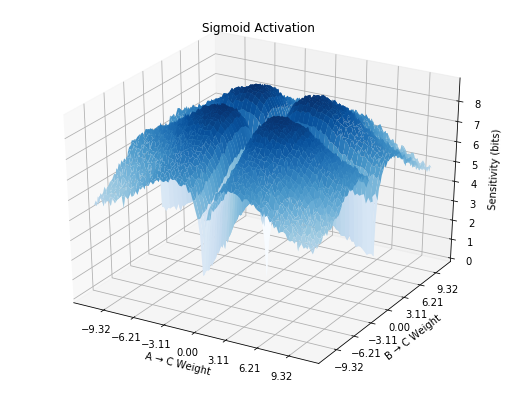

In [6]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -np.e * 4.0, np.e * 4.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

sens = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    sen = sensitivity_of_layer(tiny_network, top, samples=500, batch_size=500, bins=bins, 
                     in_range=(0, 1), out_range=(0, 1), activation=nn.Sigmoid(), device=device)
    sens.append(sen)
    
zs = np.array(sens)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(size / 7))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(size / 7))

ax.set_title("Sigmoid Activation")
ax.set_xlabel('A → C Weight')
ax.set_ylabel('B → C Weight')
ax.set_zlabel('Sensitivity (bits)')

# plt.savefig("figures/sensitivity-sigmoid-2d-blue", dpi=300)

## Let's see how it converges:

In [7]:
network = nn.Linear(100, 100, bias=False).to(device)
top = topology_of(network, input=torch.zeros((1, 100)).to(device))

for s in [10, 25, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    sensitivity = sensitivity_of_layer(network, top, 
                                       samples=s, 
                                       batch_size=500, 
                                       bins=64, 
                                       in_range=(0, 1), 
                                       out_range=(0, 1), 
                                       activation=nn.Sigmoid(), 
                                       device=device)
    print("samples: {0:5d} | sensitivity: {1:.5f}".format(s, sensitivity))

samples:    10 | sensitivity: 2373.31066
samples:    25 | sensitivity: 2393.38072
samples:    50 | sensitivity: 2558.02873
samples:   100 | sensitivity: 2506.48667
samples:   200 | sensitivity: 2542.00682
samples:   500 | sensitivity: 2548.68211
samples:  1000 | sensitivity: 2557.62501
samples:  2000 | sensitivity: 2551.19363
samples:  5000 | sensitivity: 2552.34178
samples: 10000 | sensitivity: 2552.89319


### We see that independent of network size, sensitivity converges very well with 500 samples per input activation

In [8]:
network = nn.Linear(20, 20, bias=False).to(device)
top = topology_of(network, input=torch.zeros((1, 20)).to(device))

sensitivity = sensitivity_of_layer(network, top, 
                                   samples=500, 
                                   batch_size=500, 
                                   bins=64, 
                                   in_range=(0, 1), 
                                   out_range=(0, 1), 
                                   activation=nn.Sigmoid(), 
                                   device=device)
ei = EI_of_layer(network, top,
                samples=3000000,
                batch_size=40,
                bins=64,
                in_range=(0, 1),
                out_range=(0, 1),
                activation=nn.Sigmoid(),
                device=device)
print("sensitivity: {0:.4f}".format(sensitivity))
print("ei         : {0:.4f}".format(ei))

sensitivity: 367.9531
ei         : 15.0618
